# Blastocyst Development in Mice: Single Cell TaqMan Arrays

#### Max Zwiessele, Oliver Stegle, Neil Lawrence 12th May 2014 University of Sheffield and EBI.

#### presented at the EBI BioPreDyn Course 'The Systems Biology Modelling Cycle'

In this notebook we follow  <a name="ref-1"/>[(Buettner and Theis, 2012)](#cite-Buettner2012A-novel) and use the GP-LVM to analyze some single cell data from <a name="ref-1"/>[(Guo et al., 2010)](#cite-Guo2010Resolution). They performed qPCR TaqMan array on single cells from the developing blastocyst in mouse. The data is taken from the early stages of development when the Blastocyst is forming. At the 32 cell stage the data is already separated into the trophectoderm (TE) which goes onto form the placenta and the inner cellular mass (ICM). The ICM further differentiates into the epiblast (EPI)---which gives rise to the endoderm, mesoderm and ectoderm---and the primitive endoderm (PE) which develops into the amniotic sack. Guo et al selected 48 genes for expression measurement. They labelled the resulting cells and their labels are included as an aide to visualization.

In the paper, they first visualized their data using principal component analysis. In the first two principal components this fails to separate the domains. This is perhaps because the principal components are dominated by the variation in the 64 cell systems. This in turn may be because there are more cells from the data set in that regime, or additionally it could be that the natural variation across the 64 cell systems is greater. Both are probable causes of the dominance of these cells in the first two principal components. The first thing we do is plot the principal coordinates of the cells on the first two dominant directions. 

### This Notebook

In this notebook we will perform PCA on the original data, showing that the different regimes do not separate. Then, we follow <a name="ref-3"/>[(Buettner and Theis, 2012)](#cite-Buettner2012A-novel) in applying the GP-LVM to the data. There is a slight pathology in the result, one which they fixed by using priors that were dependent on the developmental stage. We then show how the Bayesian GP-LVM doesn't exhibit those pathologies and gives nice results that seems to show the lineage of the cells. 

First we perform some set up.

In [1]:
import pods, GPy, itertools
%matplotlib inline
from matplotlib import pyplot as plt

Next we load in the data. We've provided a convenience function for loading in the data with GPy. It is loaded in as a `pandas` DataFrame. This allows us to summarize it with the `describe` attribute.

In [2]:
s = pods.datasets.singlecell()
Ydf = s['Y']
Y = Ydf.values
labels = s['labels']
marker = '<>^vsd'
Ydf.describe()

,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
count,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,...,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02
mean,2.089245e-08,2.400458e-08,3.011442e-08,2.009153e-08,1.416476e-08,2.661327e-08,1.828375e-08,2.329519e-08,2.993135e-08,2.077803e-08,...,2.180778e-08,2.146453e-08,2.077803e-08,2.585812e-08,2.473684e-08,2.670481e-08,2.009153e-08,2.231121e-08,2.263158e-08,2.606407e-08
std,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,...,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00
min,-2.997659e+00,-2.140030e+00,-1.768643e+00,-2.355953e+00,-4.420191e+00,-1.972546e+00,-2.493296e+00,-2.290915e+00,-1.641875e+00,-1.755517e+00,...,-2.246728e+00,-2.015028e+00,-2.960914e+00,-1.964500e+00,-2.033562e+00,-1.886886e+00,-2.238215e+00,-2.089612e+00,-1.825355e+00,-2.035440e+00
25%,-7.169942e-01,-7.796685e-01,-7.171038e-01,-9.337937e-01,-2.516838e-01,-6.446426e-01,-7.717112e-01,-8.545864e-01,-6.703301e-01,-1.018770e+00,...,-7.734272e-01,-9.343944e-01,-6.515803e-01,-7.255418e-01,-7.276985e-01,-8.376303e-01,-9.886838e-01,-9.197137e-01,-9.236930e-01,-7.673579e-01
50%,9.227372e-02,-1.782182e-01,-1.842611e-01,2.928931e-01,2.146358e-01,-1.353097e-01,2.772327e-01,-6.806050e-02,-2.415102e-01,1.097815e-01,...,7.709900e-03,8.293864e-02,-3.701860e-02,-1.972392e-01,-1.336842e-01,-2.656403e-01,2.828122e-01,-1.836380e-02,-1.127644e-01,-2.462695e-01
75%,6.808323e-01,6.245760e-01,3.312916e-01,8.234601e-01,6.738631e-01,4.854397e-01,8.213037e-01,9.125241e-01,4.854736e-01,9.259312e-01,...,8.608111e-01,8.312436e-01,6.177259e-01,1.082358e+00,5.329677e-01,9.967453e-01,8.099583e-01,1.022974e+00,8.257577e-01,6.422915e-01
max,2.490650e+00,3.564713e+00,2.627702e+00,1.687127e+00,1.569268e+00,3.427747e+00,1.826346e+00,1.729923e+00,2.780331e+00,1.671790e+00,...,1.709987e+00,4.489121e+00,3.565258e+00,1.655467e+00,2.231074e+00,2.104293e+00,4.187598e+00,1.808619e+00,2.208022e+00,2.270316e+00


### Principal Component Analysis

Now we follow Guo et al in performing PCA on the data. Rather than calling a 'PCA routine', here we break the algorithm down into its steps: compute the data covariance, compute the eigenvalues and eigenvectors and sort according to magnitude of eigenvalue. Because we want to visualize the data, we've chose to compute the eigenvectors of the *inner product matrix* rather than the covariance matrix. This allows us to plot the eigenvalues directly. However, this is less efficient (in this case because the number of genes is smaller than the number of data) than computing the eigendecomposition of the covariance matrix.

In [3]:
import numpy as np
# obtain a centred version of data.
centredY = Y - Y.mean()
# compute inner product matrix
C = np.dot(centredY,centredY.T)
# perform eigendecomposition
V, U = np.linalg.eig(C)
# sort eigenvalues and vectors according to size
ind = V.argsort()  
ev = V[ind[::-1]]
U = U[:, ind[::-1]]

Here we will define a little routine, which puts the legend on the right side of the plot, so that the legend does not overwright the data plot

In [4]:
def legend_to_the_right(ax):
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, box.height])
    _ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), numpoints=1)
    
def plot_latent(ax, x, y, marker, labels):
    GPy.plotting.Tango.reset()
    # make sure labels are in order of input:
    ulabels = []
    for lab in labels:
        if not lab in ulabels:
            ulabels.append(lab)
    for i, [label, m] in enumerate(zip(ulabels, itertools.cycle(marker))):
        symbol = marker[i % len(marker)]
        ind = labels == label
        ax.plot(x[ind], y[ind], marker=symbol, 
                   markerfacecolor=GPy.plotting.Tango.nextMedium(), 
                linestyle='',   
                label=label, mew=.2, alpha=1)

### PCA Result

Now, using the helper function we can plot the results with appropriate labels.

 /Users/maxz/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning:Casting complex values to real discards the imaginary part


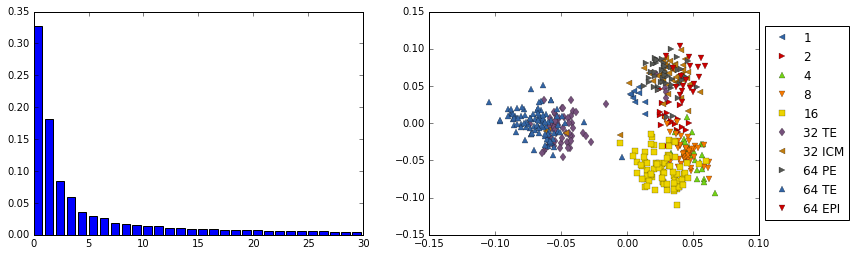

In [5]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(13,4))

fracs = (ev.real/ev.real.sum())[:30] # Take only the first 30 eigenvalues

ax1.bar(np.arange(len(fracs)), fracs)

plot_latent(ax2, U[:,0], U[:,1], marker, labels)
legend_to_the_right(ax2)

### GP-LVM on the Data

<a href="http://bioinformatics.oxfordjournals.org/content/28/18/i626.long">Buettner and Theis</a> applied a Gaussian process latent variable model to the data, but with a modified prior to ensure that small differences between cells at the same differential stage were preserved. Here we apply a standard GP-LVM (no modified prior) to the data.  

In [6]:
m = GPy.models.GPLVM(Y, 2, kernel=GPy.kern.RBF(2, ARD=1)+GPy.kern.Bias(2))
m.optimize(messages=1)

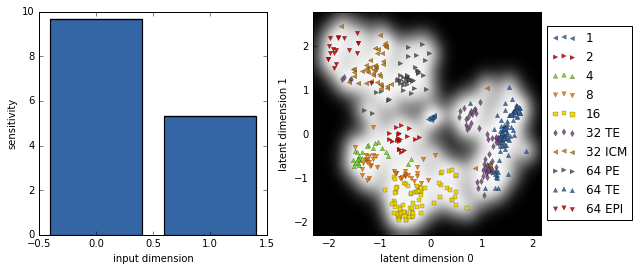

In [7]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(9,4))

m.kern.plot_ARD(ax=ax1)
m.plot_latent(labels=labels, marker=marker, legend=False, ax=ax2)

_ = legend_to_the_right(ax2)

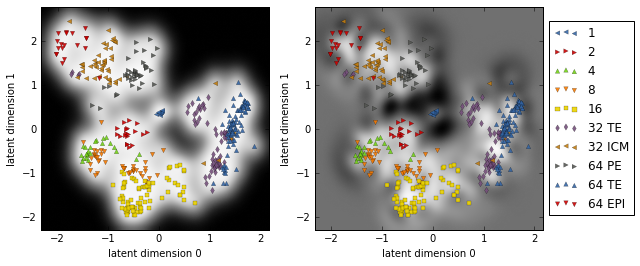

In [8]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(9,4))
m.plot_latent(labels=labels, marker=marker, legend=False, ax=ax1)
m.plot_magnification(labels=labels, marker=marker, legend=False, ax=ax2)
_ = legend_to_the_right(ax2)

This shows nicely the differences in the dataset. 

 - Cell stage 1 is very different from the other cellstages (low magnification to other cells). 
 - Other stages are closely related within (4-16) and (32-64). 
 
This does not show the developmental process, though, as the connection between stages 16 and 32 is not reflected in the latent space.

### Bayesian GP-LVM

Finally we show the new code that uses the Bayesian GP-LVM to fit the data. This means we can automatically determine the dimensionality of the model whilst fitting a non-linear dimensionality reduction. The approximations we use also mean that it is faster than the original GP-LVM.

In [9]:
m = GPy.models.BayesianGPLVM(Y, 5, num_inducing=15, kernel=GPy.kern.RBF(5,ARD=1))
m.optimize('bfgs', max_iters=5e3, messages=1)

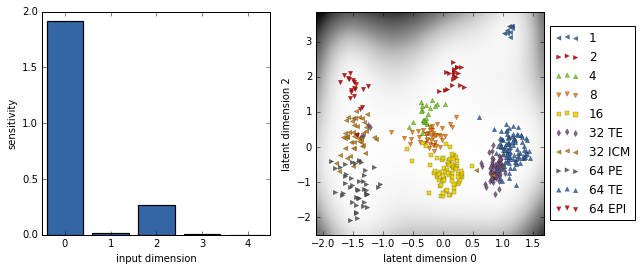

In [10]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(9,4))

m.kern.plot_ARD(ax=ax1)
m.plot_latent(labels=s['labels'], marker='<>^vsd', legend=False, ax=ax2)

legend_to_the_right(ax2)

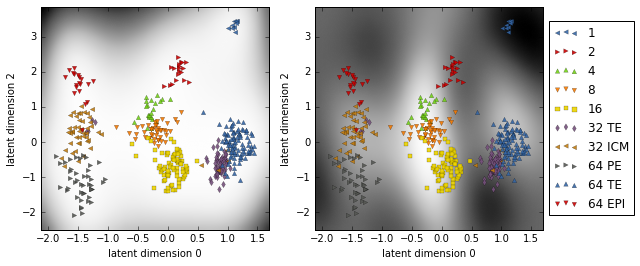

In [11]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(9,4))
m.plot_latent(labels=labels, marker=marker, legend=False, ax=ax1)
m.plot_magnification(labels=labels, marker=marker, legend=False, ax=ax2)
_ = legend_to_the_right(ax2)

This gives a really nice result. Broadly speaking two latent dimensions dominate the representation. When we visualize using these two dimensions we can see the entire cell phylogeny laid out nicely in the two dimensions. Additionally we can see the missclassification of the some cells, using the 'standard' approach of repeated k-means clustering and PCA on sub clustered (This was used to get the sample colors of the 64 cellstage).

### Other Nonlinear Approaches

How do other non-linear approaches compare with the GP-LVM? We can use scikit-learn to try a few. First we consider Isomap, which often performs really well on data.

### Isomap

Isomap first builds a neighbourhood graph, and then uses distances along this graph to approximate the geodesic distance between points. These distances are then visualized by performing classical multidimensional scaling (which involves computing the eigendecomposition of the centred distance matrix). As the neighborhood size is increased to match the data, principal component analysis is recovered (or strictly speaking, principal coordinate analysis). The fewer the neighbors, the more 'non-linear' the isomap embeddings are. 

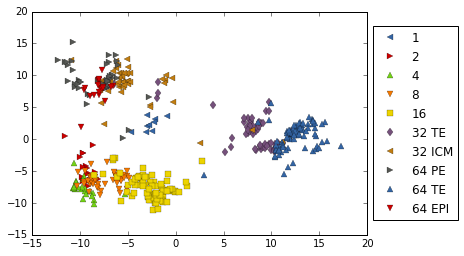

In [12]:
n_neighbors = 40
import sklearn.manifold
m = sklearn.manifold.Isomap(n_neighbors=n_neighbors, n_components=2)
X = m.fit_transform(Ydf)
fig, ax = plt.subplots(1)
plot_latent(ax, X[:, 0], X[:, 1], marker, labels)
_ = legend_to_the_right(ax)

### Locally Linear Embedding

Next we try locally linear embedding. In locally linear embedding a neighborhood is also computed. Each point is then reconstructed by it's neighbors using a linear weighting. This implies a locally linear patch is being fitted to the data in that region. These patches are assimilated into a large $n\times n$ matrix and a lower dimensional data set which reflects the same relationships is then sought. Quite a large number of neighbours needs to be selected for the data to not collapse in on itself. When a large number of neighbours is selected the embedding is more linear and begins to look like PCA. However, the algorithm does *not* converge to PCA in the limit as the number of neighbors approaches $n$. 

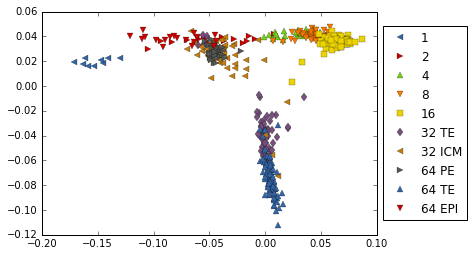

In [13]:
n_neighbors = 30
m = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2)
X = m.fit_transform(Y)
fig, ax = plt.subplots(1)
plot_latent(ax, X[:, 0], X[:, 1], marker, labels)
_ = legend_to_the_right(ax)

### t-SNE (t-distributed Stochastic Neighbour Embedding)

t-SNE does a great job in unravelling the structure of the data itself. It also shows the misslabelling of the later data quite clearly. It is not able to put the right order in the TE side, though.

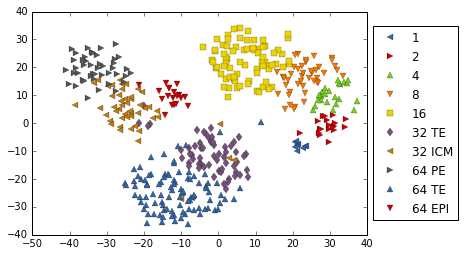

In [14]:
m = sklearn.manifold.TSNE(n_components=2)
X = m.fit_transform(Y)
fig, ax = plt.subplots(1)
plot_latent(ax, X[:, 0], X[:, 1], marker, labels)
_ = legend_to_the_right(ax)

#### work funded by the BioPreDyn and MLPM projects, it is a collaboration with Nicolas Durrande, Johannes Jaeger.

<!--bibtex


@article{Buettner2012A-novel,
	Author = {Buettner, Florian and Theis, Fabian J},
	Date-Added = {2013-03-19 19:00:08 +0000},
	Date-Modified = {2013-04-04 08:25:41 +0000},
	Journal = {Bioinformatics},
	Number = {18},
	Pages = {i626--i632},
	Publisher = {Oxford Univ Press},
	Title = {{A} novel approach for resolving differences in single-cell gene expression patterns from zygote to blastocyst},
	Volume = {28},
	Year = {2012},
    url = {http://bioinformatics.oxfordjournals.org/content/28/18/i626.full.pdf},
	Bdsk-File-1 = {YnBsaXN0MDDUAQIDBAUGJCVYJHZlcnNpb25YJG9iamVjdHNZJGFyY2hpdmVyVCR0b3ASAAGGoKgHCBMUFRYaIVUkbnVsbNMJCgsMDxJXTlMua2V5c1pOUy5vYmplY3RzViRjbGFzc6INDoACgAOiEBGABIAFgAdccmVsYXRpdmVQYXRoWWFsaWFzRGF0YV8QXEJpYmxpb2dyYXBoeS9hcnRpY2xlL0J1ZXR0bmVyL0Egbm92ZWwgYXBwcm9hY2ggZm9yIHJlc29sdmluZyBkaWZmZXJlbmNlcyBpbiBzaW5nbGUtY2VsbDAucGRm0hcLGBlXTlMuZGF0YU8RAnIAAAAAAnIAAgAADE1hY2ludG9zaCBIRAAAAAAAAAAAAAAAAAAAAM1lCtpIKwAAAC4JgR9BIG5vdmVsIGFwcHJvYWNoIGZvciMyRTBCNjMucGRmAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALgtjzXIZTgAAAAAAAAAAAAEABQAACSAAAAAAAAAAAAAAAAAAAAAIQnVldHRuZXIAEAAIAADNZQraAAAAEQAIAADNchlOAAAAAQAcAC4JgQAuCLAALgirAC4IdgAMtSkABcaDAAIQ6QACAGpNYWNpbnRvc2ggSEQ6VXNlcnM6AG1heHo6AERyb3Bib3g6AFBhcGVyOgBCaWJsaW9ncmFwaHk6AGFydGljbGU6AEJ1ZXR0bmVyOgBBIG5vdmVsIGFwcHJvYWNoIGZvciMyRTBCNjMucGRmAA4AfgA+AEEAIABuAG8AdgBlAGwAIABhAHAAcAByAG8AYQBjAGgAIABmAG8AcgAgAHIAZQBzAG8AbAB2AGkAbgBnACAAZABpAGYAZgBlAHIAZQBuAGMAZQBzACAAaQBuACAAcwBpAG4AZwBsAGUALQBjAGUAbABsADAALgBwAGQAZgAPABoADABNAGEAYwBpAG4AdABvAHMAaAAgAEgARAASAHVVc2Vycy9tYXh6L0Ryb3Bib3gvUGFwZXIvQmlibGlvZ3JhcGh5L2FydGljbGUvQnVldHRuZXIvQSBub3ZlbCBhcHByb2FjaCBmb3IgcmVzb2x2aW5nIGRpZmZlcmVuY2VzIGluIHNpbmdsZS1jZWxsMC5wZGYAABMAAS8AABUAAgAL//8AAIAG0hscHR5aJGNsYXNzbmFtZVgkY2xhc3Nlc11OU011dGFibGVEYXRhox0fIFZOU0RhdGFYTlNPYmplY3TSGxwiI1xOU0RpY3Rpb25hcnmiIiBfEA9OU0tleWVkQXJjaGl2ZXLRJidUcm9vdIABAAgAEQAaACMALQAyADcAQABGAE0AVQBgAGcAagBsAG4AcQBzAHUAdwCEAI4A7QDyAPoDcANyA3cDggOLA5kDnQOkA60DsgO/A8ID1APXA9wAAAAAAAACAQAAAAAAAAAoAAAAAAAAAAAAAAAAAAAD3g==}}


@article{Guo2010Resolution,
	Author = {Guo, Guoji and Huss, Mikael and Tong, Guo Qing and Wang, Chaoyang and Li Sun, Li and Clarke, Neil D and Robson, Pauldalerba},
	Date-Added = {2013-03-19 18:59:18 +0000},
	Date-Modified = {2013-04-04 08:25:41 +0000},
	Journal = {Developmental cell},
	Number = {4},
	Pages = {675--685},
	Publisher = {Elsevier},
	Title = {{R}esolution of cell fate decisions revealed by single-cell gene expression analysis from zygote to blastocyst},
	Volume = {18},
	Year = {2010},
    url = {http://dx.doi.org/10.1016/j.devcel.2010.02.012},
	Bdsk-File-1 = {YnBsaXN0MDDUAQIDBAUGJCVYJHZlcnNpb25YJG9iamVjdHNZJGFyY2hpdmVyVCR0b3ASAAGGoKgHCBMUFRYaIVUkbnVsbNMJCgsMDxJXTlMua2V5c1pOUy5vYmplY3RzViRjbGFzc6INDoACgAOiEBGABIAFgAdccmVsYXRpdmVQYXRoWWFsaWFzRGF0YV8QSEJpYmxpb2dyYXBoeS9hcnRpY2xlL0d1by9SZXNvbHV0aW9uIG9mIGNlbGwgZmF0ZSBkZWNpc2lvbnMgcmV2ZWFsZWQwLnBkZtIXCxgZV05TLmRhdGFPEQI4AAAAAAI4AAIAAAxNYWNpbnRvc2ggSEQAAAAAAAAAAAAAAAAAAADNZQraSCsAAAAuCVUfUmVzb2x1dGlvbiBvZiBjZWxsIGYjMkUwQzNCLnBkZgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC4MO81nvA4AAAAAAAAAAAABAAUAAAkgAAAAAAAAAAAAAAAAAAAAA0d1bwAAEAAIAADNZQraAAAAEQAIAADNZ7wOAAAAAQAcAC4JVQAuCLAALgirAC4IdgAMtSkABcaDAAIQ6QACAGVNYWNpbnRvc2ggSEQ6VXNlcnM6AG1heHo6AERyb3Bib3g6AFBhcGVyOgBCaWJsaW9ncmFwaHk6AGFydGljbGU6AEd1bzoAUmVzb2x1dGlvbiBvZiBjZWxsIGYjMkUwQzNCLnBkZgAADgBgAC8AUgBlAHMAbwBsAHUAdABpAG8AbgAgAG8AZgAgAGMAZQBsAGwAIABmAGEAdABlACAAZABlAGMAaQBzAGkAbwBuAHMAIAByAGUAdgBlAGEAbABlAGQAMAAuAHAAZABmAA8AGgAMAE0AYQBjAGkAbgB0AG8AcwBoACAASABEABIAYVVzZXJzL21heHovRHJvcGJveC9QYXBlci9CaWJsaW9ncmFwaHkvYXJ0aWNsZS9HdW8vUmVzb2x1dGlvbiBvZiBjZWxsIGZhdGUgZGVjaXNpb25zIHJldmVhbGVkMC5wZGYAABMAAS8AABUAAgAL//8AAIAG0hscHR5aJGNsYXNzbmFtZVgkY2xhc3Nlc11OU011dGFibGVEYXRhox0fIFZOU0RhdGFYTlNPYmplY3TSGxwiI1xOU0RpY3Rpb25hcnmiIiBfEA9OU0tleWVkQXJjaGl2ZXLRJidUcm9vdIABAAgAEQAaACMALQAyADcAQABGAE0AVQBgAGcAagBsAG4AcQBzAHUAdwCEAI4A2QDeAOYDIgMkAykDNAM9A0sDTwNWA18DZANxA3QDhgOJA44AAAAAAAACAQAAAAAAAAAoAAAAAAAAAAAAAAAAAAADkA==}}

-->

# References

<a name="cite-Buettner2012A-novel"/><sup>[^](#ref-1) [^](#ref-3) </sup>Buettner, Florian and Theis, Fabian J. 2012. _A novel approach for resolving differences in single-cell gene expression patterns from zygote to blastocyst_. [URL](http://bioinformatics.oxfordjournals.org/content/28/18/i626.full.pdf)

<a name="cite-Guo2010Resolution"/><sup>[^](#ref-2) </sup>Guo, Guoji and Huss, Mikael and Tong, Guo Qing and Wang, Chaoyang and Li Sun, Li and Clarke, Neil D and Robson, Pauldalerba. 2010. _Resolution of cell fate decisions revealed by single-cell gene expression analysis from zygote to blastocyst_. [URL](http://dx.doi.org/10.1016/j.devcel.2010.02.012)

